In [68]:
import collections

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_federated as tff

In [2]:
random_state = np.random.RandomState(42)

In [3]:
tff.federated_computation(lambda: "Hello World!")()

'Hello World!'

# Preparing the data

In [2]:
tff.simulation.datasets.emnist.load_data?

Signature: tff.simulation.datasets.emnist.load_data(only_digits=True, cache_dir=None)
Docstring:
Loads the Federated EMNIST dataset.

Downloads and caches the dataset locally. If previously downloaded, tries to
load the dataset from cache.

This dataset is derived from the Leaf repository
(https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
dataset, grouping examples by writer. Details about Leaf were published in
"LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.

*Note*: This dataset does not include some additional preprocessing that
MNIST includes, such as size-normalization and centering.
In the Federated EMNIST data, the value of 1.0
corresponds to the background, and 0.0 corresponds to the color of the digits
themselves; this is the *inverse* of some MNIST representations,
e.g. in [tensorflow_datasets]
(https://github.com/tensorflow/datasets/blob/master/docs/datasets.md#mnist),
where 0 corresponds to the background color, and 255 

In [4]:
emnist_train, emnist_test = (tff.simulation
                                .datasets
                                .emnist
                                .load_data(only_digits=True, cache_dir="../data"))


/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [5]:
# these are what the client ids look like
emnist_train.client_ids[:10]

['f0000_14',
 'f0001_41',
 'f0005_26',
 'f0006_12',
 'f0008_45',
 'f0011_13',
 'f0014_19',
 'f0016_39',
 'f0017_07',
 'f0022_10']

In [6]:
n_clients = len(emnist_train.client_ids)
n_clients

3383

In [9]:
_random_idx = random_state.randint(n_clients)
random_client = emnist_train.client_ids[_random_idx]
client_dataset = emnist_train.create_tf_dataset_for_client(random_client)

In [10]:
# here is TensorFlow Dataset for a particular client
client_dataset

<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>

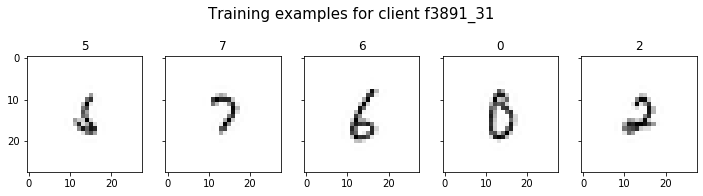

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(12,6), sharex=True, sharey=True)
for i, example in enumerate(client_dataset.take(5)):
    axes[i].imshow(example["pixels"].numpy(), cmap="gray")
    axes[i].set_title(example["label"].numpy())
_ = fig.suptitle(x= 0.5, y=0.75, t=f"Training examples for client {random_client}", fontsize=15)   


Feature distribution skew(covariate shift): The marginal distributionsPi(x)may vary across clients,even ifP(y|x)is shared.4For example, in a handwriting recognition domain, users who write thesame words might still have different stroke width, slant, etc.

Since each client dataset is already a `tf.data.Dataset`, preprocessing can be accomplished using Dataset transformations. If client datasets are stored in some other format then could use preprocessing operations from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html).

Here, we flatten the 28x28 images into 784-element arrays, shuffle the individual examples, organize them into batches, and renames the features from pixels and label to x and y for use with Keras. We also throw in a repeat over the data set to run several epochs.

In [110]:
AUTOTUNE = (tf.data
              .experimental
              .AUTOTUNE)
SHUFFLE_BUFFER_SIZE = 500
NUMBER_TRAINING_EPOCHS = 10
TRAINING_BATCH_SIZE = 32
TESTING_BATCH_SIZE = 32

def _reshape(training_sample):
    """Extracts and reshapes data from a training sample """
    pixels = training_sample["pixels"]
    label = training_sample["label"]
    X = tf.reshape(pixels, shape=[-1]) # flattens 2D pixels to 1D
    y = tf.reshape(label, shape=[1])
    return X, y


def create_training_dataset(client_dataset,
                            seed=None,
                            num_parallel_calls=AUTOTUNE,
                            shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
                            number_epochs=NUMBER_TRAINING_EPOCHS,
                            batch_size=TRAINING_BATCH_SIZE,
                            prefetch_buffer_size=AUTOTUNE):
    """Create a training dataset from raw client dataset."""
    _dataset = (client_dataset.map(_reshape, num_parallel_calls)
                              .shuffle(shuffle_buffer_size, seed, reshuffle_each_iteration=True)
                              .repeat(number_epochs)
                              .batch(batch_size)
                              .prefetch(prefetch_buffer_size))
    return _dataset


def create_testing_dataset(client_dataset,
                           num_parallel_calls=AUTOTUNE,
                           batch_size=TESTING_BATCH_SIZE):
    """Create a testing dataset from raw client dataset."""
    _dataset = (client_dataset.map(_reshape, num_parallel_calls)
                              .batch(batch_size))
    return _dataset

We have almost all the building blocks in place to construct federated data sets.

One of the ways to feed federated data to TFF in a simulation is simply as a Python list, with each element of the list holding the data of an individual user, whether as a list or as a tf.data.Dataset. Since we already have an interface that provides the latter, let's use it.

Here's a simple helper function that will construct a list of datasets from the given set of users as an input to a round of training or evaluation.

In [113]:
def create_training_datasets(client_ids,
                             seed,
                             num_parallel_calls=AUTOTUNE,
                             shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
                             number_epochs=NUMBER_TRAINING_EPOCHS,
                             batch_size=TRAINING_BATCH_SIZE,
                             prefetch_buffer_size=AUTOTUNE):
    """Creates a TF Dataset for each client id."""
    training_datasets = []
    for client_id in client_ids:
        client_dataset = emnist_train.create_tf_dataset_for_client(client_id)
        training_dataset = (create_training_dataset(client_dataset,
                                                    seed,
                                                    num_parallel_calls,
                                                    shuffle_buffer_size,
                                                    number_epochs,
                                                    batch_size,
                                                    prefetch_buffer_size))
        training_datasets.append(training_dataset)
    return training_datasets


def create_testing_datasets(client_ids,
                            num_parallel_calls=AUTOTUNE,
                            batch_size=TESTING_BATCH_SIZE):
    """Creates a TF Dataset for each client id."""
    testing_datasets = []
    for client_id in client_ids:
        client_dataset = emnist_test.create_tf_dataset_for_client(client_id)
        testing_dataset = (create_testing_dataset(client_dataset,
                                                  num_parallel_calls,
                                                  batch_size))
        testing_datasets.append(testing_dataset)
    return testing_datasets

Now, how do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very large population of user devices, only a fraction of which may be available for training at a given point in time. This is the case, for example, when the client devices are mobile phones that participate in training only when plugged into a power source, off a metered network, and otherwise idle.

Of course, we are in a simulation environment, and all the data is locally available. Typically then, when running simulations, we would simply sample a random subset of the clients to be involved in each round of training, generally different in each round.

That said, as you can find out by studying the paper on the Federated Averaging algorithm, achieving convergence in a system with randomly sampled subsets of clients in each round can take a while, and it would be impractical to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and reuse the same set across rounds to speed up convergence (intentionally over-fitting to these few user's data). We leave it as an exercise for the reader to modify this tutorial to simulate random sampling - it is fairly easy to do (once you do, keep in mind that getting the model to converge may take a while).

In [14]:
def sample_client_ids(client_ids: list,
                      sample_size: float,
                      random_state: np.random.RandomState) -> list:
    """Randomly selects a subset of clients ids."""
    _size = int(sample_size * len(client_ids))
    _random_idxs = random_state.randint(n_clients, size=_size)
    return [client_ids[i] for i in _random_idxs]


_random_state = np.random.RandomState(42)
_client_ids = sample_client_ids(emnist_train.client_ids, 0.01, _random_state)
federated_training_data = create_training_datasets(_client_ids, seed=42)

In [15]:
len(federated_training_data)

33

In [16]:
sample_batch = (tf.nest
                  .map_structure(lambda tensor: tensor.numpy(), iter(federated_training_data[0]).next()))

sample_batch

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
 array([[1],
        [6],
        [2],
        [6],
        [2],
        [3],
        [3],
        [7],
        [4],
        [0],
        [0],
        [7],
        [7],
        [6],
        [5],
        [1],
        [2],
        [8],
        [9],
        [2],
        [3],
        [8],
        [7],
        [3],
        [0],
        [8],
        [6],
        [8],
        [9],
        [6],
        [8],
        [2]], dtype=int32))

# Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras model. Here's an example of a simple model that will suffice for our needs.

In [119]:
tff.learning.from_keras_model?

Signature:
tff.learning.from_keras_model(
    keras_model,
    dummy_batch,
    loss,
    loss_weights=None,
    metrics=None,
    optimizer=None,
)
Docstring:
Builds a `tff.learning.Model` for an example mini batch.

Args:
  keras_model: A `tf.keras.Model` object that is not compiled.
  dummy_batch: A nested structure of values that are convertible to *batched*
    tensors with the same shapes and types as would be input to `keras_model`.
    The values of the tensors are not important and can be filled with any
    reasonable input value.
  loss: A callable that takes two batched tensor parameters, `y_true` and
    `y_pred`, and returns the loss. If the model has multiple outputs, you can
    use a different loss on each output by passing a dictionary or a list of
    losses. The loss value that will be minimized by the model will then be
    the sum of all individual losses, each weighted by `loss_weights`.
  loss_weights: (Optional) a list or dictionary specifying scalar coefficien

In [120]:
NUMBER_FEATURES = 784

def create_tff_model_fn(model_fn, loss_fn, metrics, optimizer):
    
    def tff_model_fn():
        dummy_batch = (tf.constant(0.0, shape=(TRAINING_BATCH_SIZE, NUMBER_FEATURES), dtype=tf.float32),
                       tf.constant(0, shape=(TRAINING_BATCH_SIZE, 1), dtype=tf.int32))
        tff_model = (tff.learning
                        .from_keras_model(model_fn, dummy_batch, loss_fn, None, metrics, optimizer))
        return tff_model
    
    return tff_model_fn

In [45]:
def keras_model_fn():
    model_fn = keras.models.Sequential([
        keras.layers.Dense(10, activation=tf.nn.softmax, kernel_initializer='zeros', input_shape=(NUMBER_FEATURES,))
    ])

    loss_fn = (keras.losses
                    .SparseCategoricalCrossentropy())
    optimizer = (keras.optimizers
                      .SGD(learning_rate=0.02))
    metrics = [
       keras.metrics.SparseCategoricalAccuracy()
    ]
    
    # optimizer only used to compute local model updates on each client
    model_fn.compile(optimizer, loss_fn, metrics)
    
    return model_fn

One critical note on compile. When used in the Federated Averaging algorithm, as below, the optimizer is only half of the total optimization algorithm, as it is only used to compute local model updates on each client. The rest of the algorithm involves how these updates are averaged over clients, and how they are then applied to the global model at the server. In particular, this means that the choice of optimizer and learning rate used here may need to be different than the ones you have used to train the model on a standard i.i.d. dataset. We recommend starting with regular SGD, possibly with a smaller learning rate than usual. The learning rate we use here has not been carefully tuned, feel free to experiment.

One critical note on compile. When used in the Federated Averaging algorithm, as below, the optimizer is only half of the total optimization algorithm, as it is only used to compute local model updates on each client. The rest of the algorithm involves how these updates are averaged over clients, and how they are then applied to the global model at the server. In particular, this means that the choice of optimizer and learning rate used here may need to be different than the ones you have used to train the model on a standard i.i.d. dataset. We recommend starting with regular SGD, possibly with a smaller learning rate than usual. The learning rate we use here has not been carefully tuned, feel free to experiment.

In [71]:
tff.learning.from_compiled_keras_model?

Signature: tff.learning.from_compiled_keras_model(keras_model, dummy_batch)
Docstring:
Builds a `tff.learning.Model` for an example mini batch.

Args:
  keras_model: A `tf.keras.Model` object that was compiled.
  dummy_batch: A nested structure of values that are convertible to *batched*
    tensors with the same shapes and types as expected by `forward_pass()`.
    The values of the tensors are not important and can be filled with any
    reasonable input value.

Returns:
  A `tff.learning.Model`.

Raises:
  TypeError: If `keras_model` is not an instance of `tf.keras.Model`.
  ValueError: If `keras_model` was *not* compiled.
File:      ~/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/learning/keras_utils.py
Type:      function


In [63]:
def tff_model_fn():
    keras_model = keras_model_fn()
    
    # batch of data used to initialize parts of keras model (values irrelevant!)
    dummy_batch = (tf.constant(0.0, shape=(TRAINING_BATCH_SIZE, NUMBER_FEATURES), dtype=tf.float32),
                   tf.constant(0, shape=(TRAINING_BATCH_SIZE, 1), dtype=tf.int32))
    
    tff_model = (tff.learning
                    .from_compiled_keras_model(keras_model, dummy_batch))
    
    return tff_model

# Training the model on federated data

Now that we have a model wrapped as [`tff.learning.Model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model) for use with TFF, we can let TFF construct a Federated Averaging algorithm by invoking the helper function tff.learning.build_federated_averaging_process, as follows.

Keep in mind that the argument needs to be a constructor (such as model_fn above), not an already-constructed instance, so that the construction of your model can happen in a context controlled by TFF (if you're curious about the reasons for this, we encourage you to read the follow-up tutorial on custom algorithms).

In [118]:
tff.learning.build_federated_averaging_process?

Signature:
tff.learning.build_federated_averaging_process(
    model_fn,
    server_optimizer_fn=<function <lambda> at 0x145f06d40>,
    client_weight_fn=None,
    stateful_delta_aggregate_fn=None,
    stateful_model_broadcast_fn=None,
)
Docstring:
Builds the TFF computations for optimization using federated averaging.

Args:
  model_fn: A no-arg function that returns a `tff.learning.TrainableModel`.
  server_optimizer_fn: A no-arg function that returns a `tf.Optimizer`. The
    `apply_gradients` method of this optimizer is used to apply client updates
    to the server model. The default creates a `tf.keras.optimizers.SGD` with
    a learning rate of 1.0, which simply adds the average client delta to the
    server's model.
  client_weight_fn: Optional function that takes the output of
    `model.report_local_outputs` and returns a tensor that provides the weight
    in the federated average of model deltas. If not provided, the default is
    the total number of examples processed on

In [121]:
def _server_optimizer_fn():
    optimizer = keras.optimizers.SGD(learning_rate=1.0)
    return optimizer

model_fn = keras.models.Sequential([
    keras.layers.Dense(10, activation=tf.nn.softmax, kernel_initializer='zeros', input_shape=(NUMBER_FEATURES,))
])

loss_fn = (keras.losses
                .SparseCategoricalCrossentropy())
optimizer = (keras.optimizers
                  .SGD(learning_rate=0.02))
metrics = [
   keras.metrics.SparseCategoricalAccuracy()
]
    
federated_averaging_process = (tff.learning
                                  .build_federated_averaging_process(create_tff_model_fn(model_fn, loss_fn, metrics, optimizer),
                                                                     server_optimizer_fn=_server_optimizer_fn))


ValueError: Tensor("dense_8/Identity:0", shape=(None, 10), dtype=float32) must be from the same graph as Tensor("dense_8_target:0", shape=(None, None), dtype=float32).

What just happened? TFF has constructed a pair of federated computations and packaged them into a tff.utils.IterativeProcess in which these computations are available as a pair of properties initialize and next.

In a nutshell, federated computations are programs in TFF's internal language that can express various federated algorithms (you can find more about this in the custom algorithms tutorial). In this case, the two computations generated and packed into iterative_process implement Federated Averaging.

It is a goal of TFF to define computations in a way that they could be executed in real federated learning settings, but currently only local execution simulation runtime is implemented. To execute a computation in a simulator, you simply invoke it like a Python function. This default interpreted environment is not designed for high performance, but it will suffice for this tutorial; we expect to provide higher-performance simulation runtimes to facilitate larger-scale research in future releases.

Let's start with the initialize computation. As is the case for all federated computations, you can think of it as a function. The computation takes no arguments, and returns one result - the representation of the state of the Federated Averaging process on the server. While we don't want to dive into the details of TFF, it may be instructive to see what this state looks like. You can visualize it as follows.

In [95]:
str(federated_averaging_process.initialize.type_signature)

'( -> <model=<trainable=<dense/kernel=float32[784,10],dense/bias=float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [65]:
state = federated_averaging_process.initialize()

In [66]:
state, metrics = federated_averaging_process.next(state, federated_training_data)
print(f"round: 1, metrics: {metrics}")

round: 1, metrics: <sparse_categorical_accuracy=0.12496867030858994,loss=2.6366264820098877>


Let's run a few more rounds. As noted earlier, typically at this point you would pick a subset of your simulation data from a new randomly selected sample of users for each round in order to simulate a realistic deployment in which users continuously come and go, but in this interactive notebook, for the sake of demonstration we'll just reuse the same users, so that the system converges quickly.

In [67]:
NUM_ROUNDS = 10

for n in range(2, NUM_ROUNDS):
    state, metrics = federated_averaging_process.next(state, federated_training_data)
    print(f"round:{n}, metrics:{metrics}")


round:2, metrics:<sparse_categorical_accuracy=0.15003132820129395,loss=2.5003929138183594>
round:3, metrics:<sparse_categorical_accuracy=0.18117168545722961,loss=2.4063901901245117>
round:4, metrics:<sparse_categorical_accuracy=0.21218672394752502,loss=2.298753023147583>
round:5, metrics:<sparse_categorical_accuracy=0.263627827167511,loss=2.1705288887023926>
round:6, metrics:<sparse_categorical_accuracy=0.27666041254997253,loss=2.12200665473938>
round:7, metrics:<sparse_categorical_accuracy=0.3250313401222229,loss=2.0114731788635254>
round:8, metrics:<sparse_categorical_accuracy=0.35874059796333313,loss=1.9277386665344238>
round:9, metrics:<sparse_categorical_accuracy=0.3807644248008728,loss=1.8694604635238647>


# Customizing the model implementation

Keras is the recommended high-level model API for TensorFlow and you should be using Keras models (via [`tff.learning.from_keras_model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/from_keras_model) or [`tff.learning.from_compiled_keras_model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/from_compiled_keras_model)) in TFF whenever possible.

However, tff.learning provides a lower-level model interface, tff.learning.Model, that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks like tf.keras.layers) allows for maximum customization without modifying the internals of the federated learning algorithms.

So let's do it all over again from scratch.

## Defining model variables, the forward pass, and metrics

The first step is to identify the TensorFlow variables we're going to work with. In order to make the following code more legible, let's define a data structure to represent the entire set. This will include variables such as `weights` and `bias` that we will train, as well as variables that will hold various cumulative statistics and counters we will update during training, such as `loss_sum`, `accuracy_sum`, and `num_examples`.

In [70]:
_field_names = [
    "weights",
    "bias",
    "num_examples",
    "loss_sum",
    "accuracy_sum"
]

Variables = collections.namedtuple("Variables", field_names=_field_names)

In [72]:
tf.Variable?

Init signature: tf.Variable(*args, **kwargs)
Docstring:     
See the [Variables Guide](https://tensorflow.org/guide/variables).

A variable maintains state in the graph across calls to `run()`. You add a
variable to the graph by constructing an instance of the class `Variable`.

The `Variable()` constructor requires an initial value for the variable,
which can be a `Tensor` of any type and shape. The initial value defines the
type and shape of the variable. After construction, the type and shape of
the variable are fixed. The value can be changed using one of the assign
methods.

If you want to change the shape of a variable later you have to use an
`assign` Op with `validate_shape=False`.

Just like any `Tensor`, variables created with `Variable()` can be used as
inputs for other Ops in the graph. Additionally, all the operators
overloaded for the `Tensor` class are carried over to variables, so you can
also add nodes to the graph by just doing arithmetic on variables.

```python
impo

In [91]:
def create_mnist_variables():
    _weights = tf.Variable(
        initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
        name='weights',
        trainable=True
    )
    _bias = tf.Variable(
        initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(10)),
        name='bias',
        trainable=True
    )
    _num_examples = tf.Variable(0.0, name='num_examples', trainable=False)
    _loss_sum = tf.Variable(0.0, name='loss_sum', trainable=False)
    _accuracy_sum = tf.Variable(0.0, name='accuracy_sum', trainable=False)
    return Variables(_weights, _bias, _num_examples, _loss_sum, _accuracy_sum)


With the variables for model parameters and cumulative statistics in place, we can now define the forward pass method that computes loss, emits predictions, and updates the cumulative statistics for a single batch of input data, as follows.

In [92]:
def mnist_forward_pass(variables, batch):
    Z = tf.matmul(batch['X'], variables.weights) + variables.bias
    y = tf.nn.softmax(Z)
    predictions = tf.argmax(y, axis=1, output_type=tf.int32)

    flat_labels = tf.reshape(batch['y'], [-1])
    loss = -tf.reduce_mean(tf.reduce_sum(
        tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
    accuracy = tf.reduce_mean(
        tf.cast(tf.equal(predictions, flat_labels), tf.float32))

    num_examples = tf.cast(tf.size(batch['y']), tf.float32)

    variables.num_examples.assign_add(num_examples)
    variables.loss_sum.assign_add(loss * num_examples)
    variables.accuracy_sum.assign_add(accuracy * num_examples)

    return loss, predictions


Next, we define a function that returns a set of local metrics. These are the values, in addition to model updates (which are handled automatically), that are eligible to be aggregated to the server in a federated learning or evaluation process.

Here, we simply return the average loss and accuracy, as well as the num_examples, which we'll need to correctly weight the contributions from different users when computing federated aggregates.

In [89]:
def get_local_mnist_metrics(variables):
    metrics = collections.OrderedDict([
        ('num_examples', variables.num_examples),
        ('loss', variables.loss_sum / variables.num_examples),
        ('accuracy', variables.accuracy_sum / variables.num_examples)
      ])
    return metrics


Finally, we need to determine how to aggregate the local metrics emitted by each device via get_local_mnist_metrics. This is the only part of the code that isn't written in TensorFlow - it's a federated computation expressed in TFF. If you'd like to dig deeper, skim over the custom algorithms tutorial, but in most applications, you won't really need to; variants of the pattern shown below should suffice. 

In [76]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
    aggregated_metrics = {
        'num_examples': tff.federated_sum(metrics.num_examples),
        'loss': tff.federated_mean(metrics.loss, metrics.num_examples),
        'accuracy': tff.federated_mean(metrics.accuracy, metrics.num_examples)
    }
    return aggregated_metrics


The input metrics argument corresponds to the OrderedDict returned by get_local_mnist_metrics above, but critically the values are no longer tf.Tensors - they are "boxed" as tff.Values, to make it clear you can no longer manipulate them using TensorFlow, but only using TFF's federated operators like tff.federated_mean and tff.federated_sum. The returned dictionary of global aggregates defines the set of metrics which will be available on the server.

# Creating an instance of `tff.learning.Model`

With all of the above in place, we are ready to construct a model representation for use with TFF similar to one that's generated for you when you let TFF ingest a Keras model.

In [85]:
class MNISTModel(tff.learning.Model):

    def __init__(self):
        self._variables = create_mnist_variables()
        
        self._input_spec = collections.OrderedDict([
            ('X', tf.TensorSpec([None, 784], tf.float32)),
            ('y', tf.TensorSpec([None, 1], tf.int32))
        ])

    @property
    def trainable_variables(self):
        return [self._variables.weights, self._variables.bias]

    @property
    def non_trainable_variables(self):
        return []

    @property
    def local_variables(self):
        _local_variables = [
            self._variables.num_examples,
            self._variables.loss_sum,
            self._variables.accuracy_sum
        ]
        return _local_variables

    @property
    def input_spec(self):
        return self._input_spec

    @tf.function
    def forward_pass(self, batch, training=True):
        del training # WTF!
        loss, predictions = mnist_forward_pass(self._variables, batch)
        num_examples = tf.shape(batch['X'])[0]
        
        batch_output = tff.learning.BatchOutput(
            loss=loss,
            predictions=predictions,
            num_examples=num_examples
        )
        return batch_output

    @tf.function
    def report_local_outputs(self):
        return get_local_mnist_metrics(self._variables)

    @property
    def federated_output_computation(self):
        return aggregate_mnist_metrics_across_clients


As you can see, the abstract methods and properties defined by [`tff.learning.Model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model) corresponds to the code snippets in the preceding section that introduced the variables and defined the loss and statistics.

Here are a few points worth highlighting:

* All state that your model will use must be captured as TensorFlow variables, as TFF does not use Python at runtime (remember your code should be written such that it can be deployed to mobile devices).
* Your model should describe what form of data it accepts (input_spec), as in general, TFF is a strongly-typed environment and wants to determine type signatures for all components. Declaring the format of your model's input is an essential part of it.
* Although technically not required, we recommend wrapping all TensorFlow logic (forward pass, metric calculations, etc.) as tf.functions, as this helps ensure the TensorFlow can be serialized, and removes the need for explicit control dependencies.

The above is sufficient for evaluation and algorithms like Federated SGD. However, for Federated Averaging, we need to specify how the model should train locally on each batch.

In [81]:
class MNISTrainableModel(MNISTModel, tff.learning.TrainableModel):

    @tf.function
    def train_on_batch(self, batch):
        with tf.GradientTape() as tape:
            output = self.forward_pass(batch)
        grads = tape.gradient(output.loss, self.trainable_variables)
        optimizer = tf.keras.optimizers.SGD(0.02) # don't hard code this here!
        optimizer.apply_gradients(zip(tf.nest.flatten(grads), tf.nest.flatten(self.trainable_variables)))
        return output


# Simulating federated training with the new model

With all the above in place, the remainder of the process looks like what we've seen already - just replace the model constructor with the constructor of our new model class, and use the two federated computations in the iterative process you created to cycle through training rounds.

In [96]:
federated_averaging_process = (tff.learning
                                  .build_federated_averaging_process(MNISTrainableModel))
state = federated_averaging_process.initialize()

for n in range(NUM_ROUNDS):
    
    # resample 1% of all clients at each round
    client_ids = sample_client_ids(emnist_train.client_ids, 0.01, random_state)
    federated_training_data = create_training_datasets(client_ids, seed=n)

    # perform the federated computation
    state, metrics = federated_averaging_process.next(state, federated_training_data)
    print(f"round:{n}, metrics:{metrics}")


round:0, metrics:<accuracy=0.1288272738456726,loss=2.624279499053955,num_examples=34620.0>
round:1, metrics:<accuracy=0.15038615465164185,loss=2.513991594314575,num_examples=32370.0>
round:2, metrics:<accuracy=0.19206111133098602,loss=2.393942356109619,num_examples=33380.0>
round:3, metrics:<accuracy=0.23060978949069977,loss=2.2518303394317627,num_examples=33290.0>


KeyboardInterrupt: 

# Evaluation

All of our experiments so far presented only federated training metrics - the average metrics over all batches of data trained across all clients in the round. This introduces the normal concerns about overfitting, especially since we used the same set of clients on each round for simplicity, but there is an additional notion of overfitting in training metrics specific to the Federated Averaging algorithm. This is easiest to see if we imagine each client had a single batch of data, and we train on that batch for many iterations (epochs). In this case, the local model will quickly exactly fit to that one batch, and so the local accuracy metric we average will approach 1.0. Thus, these training metrics can be taken as a sign that training is progressing, but not much more.

To perform evaluation on federated data, you can construct another federated computation designed for just this purpose, using the tff.learning.build_federated_evaluation function, and passing in your model constructor as an argument. Note that unlike with Federated Averaging, where we've used MnistTrainableModel, it suffices to pass the MnistModel. Evaluation doesn't perform gradient descent, and there's no need to construct optimizers.


In [97]:
evaluation = (tff.learning
                 .build_federated_evaluation(MNISTModel))

In [100]:
print(evaluation.type_signature)

(<<trainable=<weights=float32[784,10],bias=float32[10]>,non_trainable=<>>@SERVER,{<X=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <accuracy=float32@SERVER,loss=float32@SERVER,num_examples=float32@SERVER>)


`SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS`

No need to be concerned about the details at this point, just be aware that it takes the following general form, similar to tff.utils.IterativeProcess.next but with two important differences. 

1. We are not returning server state, since evaluation doesn't modify the model or any other aspect of state - you can think of it as stateless.
2. Evaluation only needs the model and doesn't require any other part of server state that might be associated with training, such as optimizer variables.

In [101]:
training_metrics = evaluation(state.model, federated_training_data)

In [102]:
training_metrics

AnonymousTuple([('accuracy', 0.59687597), ('loss', 1.8894539), ('num_examples', 33290.0)])

Here's what we get. Note the numbers look marginally better than what was reported by the last round of training above. By convention, the training metrics reported by the iterative training process generally reflect the performance of the model at the beginning of the training round, so the evaluation metrics will always be one step ahead.

In [115]:
# resample 1% of all clients
client_ids = sample_client_ids(emnist_test.client_ids, 0.01, random_state)
federated_testing_data = create_testing_datasets(client_ids)

/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [116]:
test_metrics = evaluation(state.model, federated_testing_data)

In [117]:
test_metrics

AnonymousTuple([('accuracy', 0.6329114), ('loss', 1.8689167), ('num_examples', 395.0)])

We encourage you to play with the parameters (e.g., batch sizes, number of users, epochs, learning rates, etc.), to modify the code above to simulate training on random samples of users in each round, 

# Exercises

Write a proper training loop that resamples the client ids to determine which client's datasets will be used for training within a round.

In [ ]:
federated_averaging_process = (tff.learning
                                  .build_federated_averaging_process(tff_model_fn))
state = federated_averaging_process.initialize()

for n in range(NUM_ROUNDS):
    
    # resample 1% of all clients at each round
    client_ids = sample_client_ids(emnist_train.client_ids, 0.01, random_state)
    federated_training_data = create_training_datasets(client_ids)

    # perform the federated computation
    state, metrics = federated_averaging_process.next(state, federated_training_data)
    print(f"round:{n}, metrics:{metrics}")


In [108]:
federated_evaluation = (tff.learning
                           .build_federated_evaluation(tff_model_fn))

# create a test set using 1% of all clients
_client_ids = sample_client_ids(emnist_test.client_ids, 0.01, random_state)
federated_testing_data = create_testing_datasets(_client_ids)

/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(
